### Using pre-trained model

Today we're going to build and fine-tune CNN based on weights pre-trained on ImageNet: the largest image classification dataset as of now.
More about imagenet: http://image-net.org/
Setup: classify from a set of 1000 classes.

In [1]:
import requests

# class labels
LABELS_URL = 'https://s3.amazonaws.com/outcome-blog/imagenet/labels.json'
labels = {int(key):value for (key, value) in requests.get(LABELS_URL).json().items()}

In [2]:
print(list(labels.items())[:5])

[(0, 'tench, Tinca tinca'), (1, 'goldfish, Carassius auratus'), (2, 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias'), (3, 'tiger shark, Galeocerdo cuvieri'), (4, 'hammerhead, hammerhead shark')]


### TorchVision
PyTorch has several companion libraries, one of them being [torchvision](https://github.com/pytorch/vision/tree/master/) - it contains a number of popular vision datasets, preprocessing tools and most importantly, [pre-trained models](https://github.com/pytorch/vision/tree/master/torchvision/models).

For now, we're going to use torch Inception-v3 module.

We're gonna use the inception-v3 network:
![img](https://hackathonprojects.files.wordpress.com/2016/09/googlenet_diagram.png?w=650&h=192)

Let's first look at the code here: [url](https://github.com/pytorch/vision/blob/master/torchvision/models/inception.py)

In [3]:
from torchvision.models.inception import inception_v3

model = inception_v3(pretrained=True,      # load existing weights
                     transform_input=True, # preprocess input image the same way as in training
                    )

model.aux_logits = False # don't predict intermediate logits (yellow layers at the bottom)
model.train(False)

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [4]:
import torch

dummy_x = torch.randn(5, 3, 299, 299)
model(dummy_x)

tensor([[-1.1646,  1.0259,  1.7418,  ..., -1.8080, -0.5049,  1.0263],
        [-1.0834,  0.9265,  1.8408,  ..., -2.0335, -0.6555,  1.5052],
        [-1.1535,  1.0637,  2.0517,  ..., -2.0420, -0.3487,  1.2355],
        [-0.9107,  1.0232,  1.9635,  ..., -2.1826, -0.5163,  1.6844],
        [-1.2811,  0.9274,  1.7673,  ..., -2.2024, -0.6045,  1.8138]],
       grad_fn=<AddmmBackward>)

### Predict class probabilities

In [5]:
# If using Colab
# !mkdir sample_images
# !wget https://raw.githubusercontent.com/yandexdataschool/Practical_DL/sem4_spring19/week04_finetuning/sample_images/albatross.jpg -O sample_images/albatross.jpg

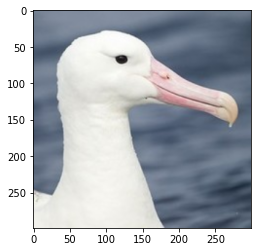

top-10 classes are: 
 [prob : class label]
0.9741 :	albatross
0.0031 :	turnstile
0.0005 :	Shetland sheepdog
0.0005 :	llama
0.0003 :	collie
0.0003 :	drake
0.0003 :	hammerhead
0.0003 :	nipple
0.0003 :	Polaroid camera


In [6]:
import matplotlib.pyplot as plt
from skimage.transform import resize
%matplotlib inline

img = resize(plt.imread('sample_images/albatross.jpg'), (299, 299))
plt.imshow(img)
plt.show()


def transform_input(img):
    return torch.as_tensor(img.reshape([1, 299, 299, 3]).transpose([0, 3, 1, 2]), dtype=torch.float32)


def predict(img):
    img = transform_input(img)
    
    probs = torch.nn.functional.softmax(model(img), dim=-1)
    
    probs = probs.data.numpy()
    
    top_ix = probs.ravel().argsort()[-1:-10:-1]
    print ('top-10 classes are: \n [prob : class label]')
    for l in top_ix:
        print ('%.4f :\t%s' % (probs.ravel()[l], labels[l].split(',')[0]))
        

predict(img)

### Having fun with pre-trained nets

In [7]:
# !wget http://cdn.com.do/wp-content/uploads/2017/02/Donal-Trum-Derogar.jpeg -O img.jpg

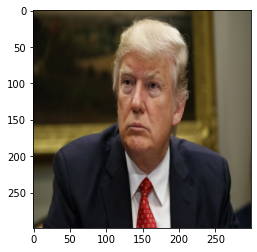

top-10 classes are: 
 [prob : class label]
0.6960 :	suit
0.0915 :	Windsor tie
0.0597 :	groom
0.0045 :	oboe
0.0039 :	academic gown
0.0034 :	Loafer
0.0033 :	wig
0.0028 :	Afghan hound
0.0027 :	bow tie


In [8]:
img = resize(plt.imread('sample_images/img.jpg'), (299, 299))
plt.imshow(img)
plt.show()

predict(img)

# Grand-quest: Dogs Vs Cats
* original competition
* https://www.kaggle.com/c/dogs-vs-cats
* 25k JPEG images of various size, 2 classes (guess what)

### Your main objective
* In this seminar your goal is to fine-tune a pre-trained model to distinguish between the two rivaling animals
* The first step is to just reuse some network layer as features

In [9]:
# !wget -nc https://www.dropbox.com/s/ae1lq6dsfanse76/dogs_vs_cats.train.zip?dl=1 -O data.zip
# !unzip -n data.zip

### How to get features
During good old days in Torch7 you could access any intermediate output from the sequential model. Nowadays it's a bit more difficult though it's not Tensorflow where you need to compile another model for that. Here we're going to redefine the last layer... yes, to do nothing.

In [10]:
import torch.nn as nn
from copy import deepcopy  # in case you still need original model

embedding = deepcopy(model)

class Identity(torch.nn.Module):

    def __init__(self):
        super(Identity, self).__init__()

    def forward(self, x):
        return x
        
    
# redefine the last layer to be Identity
embedding.fc = Identity()

assert embedding(transform_input(img)).data.numpy().shape == (1, 2048), "your output for single image should have shape (1, 2048)"

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


# for starters
* Train sklearn model, evaluate validation accuracy (should be >80%

In [12]:
embedding.cuda()
#extract features from images
from tqdm import tqdm
from imageio import imread
import PIL.Image as Image
import os
import numpy as np

X = []
Y = []

batch_size = 4
imgs = np.zeros([batch_size, 299, 299, 3])
batch_index = 0

for fname in tqdm(os.listdir('train')):
    
    y = fname.startswith("cat")
    Y.append(y)
    
    img = imread(os.path.join("train", fname))
    
    img = np.array(Image.fromarray(img).resize((299, 299))) / 255.
    imgs[batch_index] = img
    
    if batch_index == batch_size - 1:
        input_tensor = torch.as_tensor(imgs.transpose([0,3,1,2]), dtype=torch.float32, device=device)
    
        # use your embedding model to produce feature vector
        features = embedding(input_tensor).cpu().detach().numpy()
        X.append(features)
        torch.cuda.empty_cache()
        batch_index = 0
        continue
        
    batch_index += 1

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25000/25000 [13:01<00:00, 31.97it/s]


In [13]:
X = np.concatenate(X) #stack all [1xfeatures] matrices into one. 
assert X.ndim == 2
#WARNING! the concatenate works for [1xN] matrices. If you have other format, stack them yourself.

#crop if we ended prematurely
Y = np.array(Y[:len(X)])

print(X.shape, Y.shape)

(25000, 2048) (25000,)


In [14]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42) # 0.25 x 0.8 = 0.2

__load our dakka__
![img](https://s-media-cache-ak0.pinimg.com/564x/80/a1/81/80a1817a928744a934a7d32e7c03b242.jpg)

In [15]:
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

In [16]:
models = [RandomForestClassifier,ExtraTreesClassifier,AdaBoostClassifier,
         LogisticRegression, RidgeClassifier, SVC, DecisionTreeClassifier]

for sklearn_model in tqdm(models):
    classifier = sklearn_model()
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Model: {sklearn_model.__name__}, accuracy: {accuracy}")

 14%|████████████████████████▋                                                                                                                                                    | 1/7 [01:09<06:57, 69.66s/it]

Model: RandomForestClassifier, accuracy: 0.9818


 29%|█████████████████████████████████████████████████▍                                                                                                                           | 2/7 [01:25<04:27, 53.59s/it]

Model: ExtraTreesClassifier, accuracy: 0.9834


 43%|██████████████████████████████████████████████████████████████████████████▏                                                                                                  | 3/7 [04:04<05:41, 85.29s/it]

Model: AdaBoostClassifier, accuracy: 0.9804


C:\Users\acqua\miniconda3\envs\pdl\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
 57%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                          | 4/7 [04:08<03:01, 60.64s/it]

Model: LogisticRegression, accuracy: 0.9874


 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 5/7 [04:08<01:25, 42.61s/it]

Model: RidgeClassifier, accuracy: 0.988


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 6/7 [05:05<00:46, 46.86s/it]

Model: SVC, accuracy: 0.9884


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [06:43<00:00, 57.67s/it]

Model: DecisionTreeClassifier, accuracy: 0.9598


In [17]:
from sklearn.model_selection import GridSearchCV

parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
clf = GridSearchCV(SVC(), parameters)
clf.fit(X_train, y_train)

GridSearchCV(estimator=SVC(),
             param_grid={'C': [1, 10], 'kernel': ('linear', 'rbf')})

In [18]:
clf.best_params_

svc = SVC(**clf.best_params_)

svc.fit(X_train, y_train)
y_pred = classifier.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
print(f"Model: SVC, accuracy: {accuracy}")

Model: SVC, accuracy: 0.9612


# Main quest

* Get the score improved!
* You have to reach __at least 95%__ on the test set. More = better.

No methods are illegal: ensembling, data augmentation, NN hacks. 
Just don't let test data slip into training.


### Split the raw image data
  * please do train/validation/test instead of just train/test
  * reasonable but not optimal split is 20k/2.5k/2.5k or 15k/5k/5k

### Build a few layers on top of chosen "neck" layers.
  * a good idea is to just stack more layers inside the same network
  * alternative: stack on top of get_output

### Train the newly added layers for some iterations
  * you can selectively train some weights by sending the correct parameters in the optimizer
      * `opt = torch.optim.Adam([head_only.parameters()])``
  * it's cruicial to monitor the network performance at this and following steps

### Fine-tune the network body
  * probably a good idea to SAVE your new network weights now 'cuz it's easy to mess things up.
  * Moreover, saving weights periodically is a no-nonsense idea
  * even more cruicial to monitor validation performance
  * main network body may need a separate, much lower learning rate

# Bonus: #deepdream

https://twitter.com/search?q=%23deepdream&src=typd

Code is heavily based on https://github.com/thesemicolonguy/deep-dream-pytorch

Original blogpost where more ideas can be taken from: https://research.googleblog.com/2015/06/inceptionism-going-deeper-into-neural.html

In [19]:
from PIL import Image, ImageFilter, ImageChops
from torchvision import transforms
import numpy as np

In [20]:
modulelist = list(model.children())

In [21]:
preprocess = transforms.Compose([
   transforms.Resize((299, 299)),  # do we really need this now?
    transforms.ToTensor()#,
    ])


def dd_helper(image, layer, iterations, lr):
    
    #input_var = torch.as_tensor(preprocess(image).unsqueeze(0), requires_grad=True, dtype=torch.float32)
    input_var = torch.autograd.Variable(preprocess(image).unsqueeze(0), requires_grad=True)
    model.zero_grad()
    for i in range(iterations):
        out = input_var
        for j in range(layer):
            out = modulelist[j](out)
        loss = out.norm()
        loss.backward()
        input_var.data = input_var.data + lr * input_var.grad.data
    
    input_im = input_var.data.squeeze()
    input_im.transpose_(0, 1)
    input_im.transpose_(1, 2)
    input_im = np.clip(input_im, 0, 1)
    im = Image.fromarray(np.uint8(input_im * 255))
    return im


In [22]:
def deep_dream(image, layer, iterations, lr, octave_scale, num_octaves):
    if num_octaves>0:
        image1 = image.filter(ImageFilter.GaussianBlur(2))
        if (image1.size[0] / octave_scale < 1 or image1.size[1] / octave_scale < 1):
            size = image1.size
        else:
            size = (int(image1.size[0] / octave_scale), int(image1.size[1] / octave_scale))
            
        image1 = image1.resize(size, Image.ANTIALIAS)
        image1 = deep_dream(image1, layer, iterations, lr, octave_scale, num_octaves-1)
        size = (image.size[0], image.size[1])
        image1 = image1.resize(size, Image.ANTIALIAS)
        image = ImageChops.blend(image, image1, 0.6)
    print("-------------- Recursive level: ", num_octaves, '--------------')
    img_result = dd_helper(image, layer, iterations, lr)
    img_result = img_result.resize(image.size)
    plt.imshow(img_result)
    plt.axis('off')
    return img_result

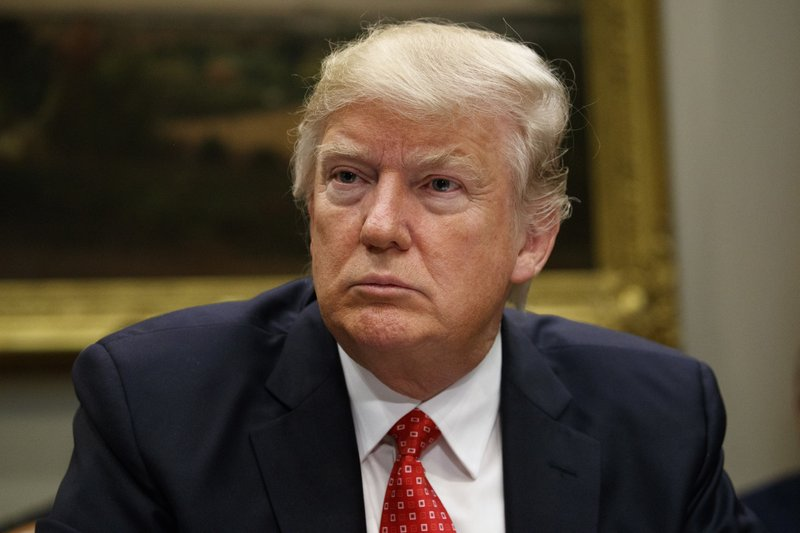

In [23]:
img = Image.fromarray(plt.imread('sample_images/img.jpg'))
img

-------------- Recursive level:  0 --------------
-------------- Recursive level:  1 --------------
-------------- Recursive level:  2 --------------
-------------- Recursive level:  3 --------------
-------------- Recursive level:  4 --------------
-------------- Recursive level:  5 --------------
-------------- Recursive level:  6 --------------
-------------- Recursive level:  7 --------------
-------------- Recursive level:  8 --------------
-------------- Recursive level:  9 --------------
-------------- Recursive level:  10 --------------
-------------- Recursive level:  11 --------------
-------------- Recursive level:  12 --------------
-------------- Recursive level:  13 --------------
-------------- Recursive level:  14 --------------
-------------- Recursive level:  15 --------------
-------------- Recursive level:  16 --------------
-------------- Recursive level:  17 --------------
-------------- Recursive level:  18 --------------
-------------- Recursive level:  19 -----

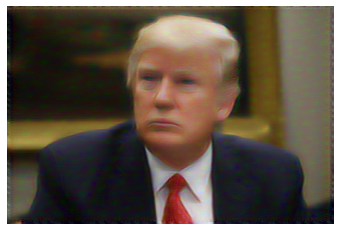

In [24]:
output = deep_dream(img, 5, 5, 0.3, 2, 20)

-------------- Recursive level:  0 --------------
-------------- Recursive level:  1 --------------


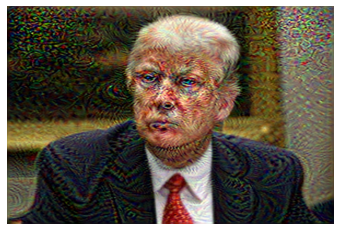

In [25]:
output = deep_dream(img, 12, 5, 0.2, 2, 1)

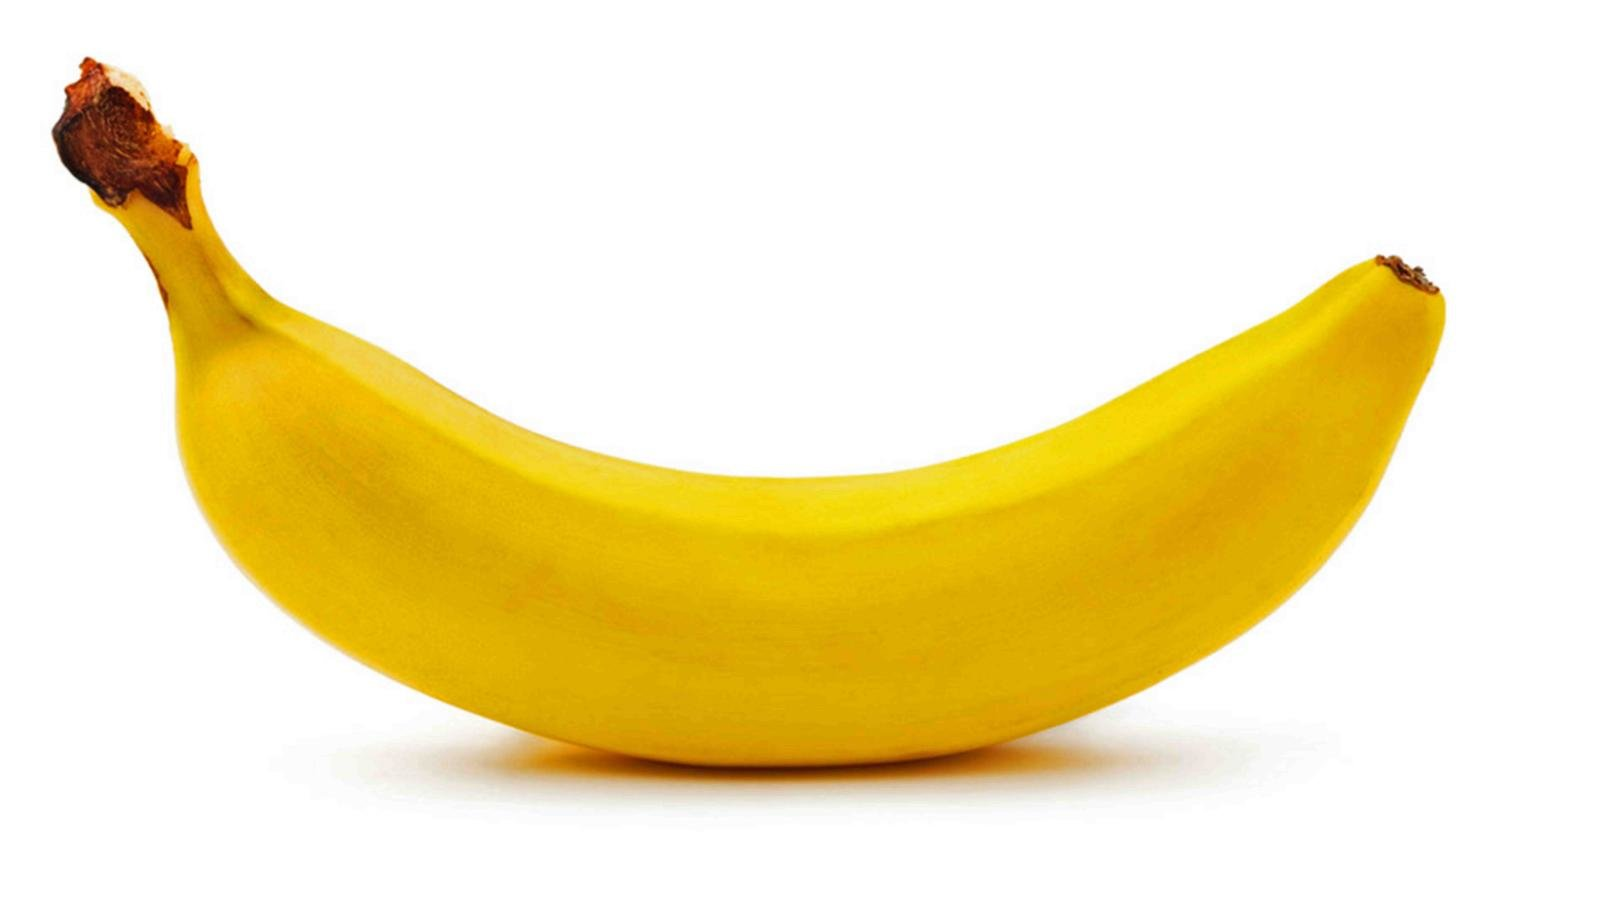

In [26]:
img = Image.fromarray(plt.imread('sample_images/banana.jpg'))
img

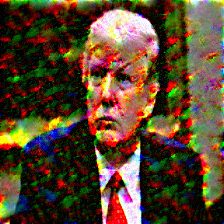

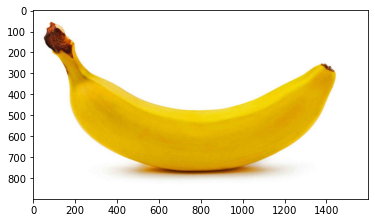

In [27]:
import numpy as np
import torch
from torch.autograd import Variable
from torch.optim import SGD
from torchvision import models, transforms
import PIL
import os
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML

import scipy.ndimage as ndimage

%matplotlib inline

import scipy.ndimage as nd
import PIL.Image
from IPython.display import clear_output, Image, display
from io import BytesIO


def showarray(a, fmt='jpeg'):
    a = np.uint8(np.clip(a, 0, 255))
    f = BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))
    
def showtensor(a):
    mean = np.array([0.485, 0.456, 0.406]).reshape([1, 1, 3])
    std = np.array([0.229, 0.224, 0.225]).reshape([1, 1, 3])
    inp = a[0, :, :, :]
    inp = inp.transpose(1, 2, 0)
    inp = std * inp + mean
    inp *= 255
    showarray(inp)
    clear_output(wait=True)

def plot_images(im, titles=None):
    plt.figure(figsize=(30, 20))
    
    for i in range(len(im)):
        plt.subplot(10 / 5 + 1, 5, i + 1)
        plt.axis('off')
        if titles is not None:
            plt.title(titles[i])
        plt.imshow(im[i])
        
    plt.pause(0.001)
    
normalise = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

normalise_resize = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

def init_image(size=(400, 400, 3)):
    img = PIL.Image.fromarray(np.uint8(np.full(size, 150)))
    img = PIL.Image.fromarray(np.uint8(np.random.uniform(150, 180, size)))
    img_tensor = normalise(img).unsqueeze(0)
    img_np = img_tensor.numpy()
    return img, img_tensor, img_np

def load_image(path, resize=False, size=None):
    img = PIL.Image.open(path)
    
    if size is not None:
        img.thumbnail(size, PIL.Image.ANTIALIAS)
        
    if resize:
        img_tensor = normalise_resize(img).unsqueeze(0)
    else:
        img_tensor = normalise(img).unsqueeze(0)
    img_np = img_tensor.numpy()
    return img, img_tensor, img_np

def tensor_to_img(t):
    a = t.numpy()
    mean = np.array([0.485, 0.456, 0.406]).reshape([1, 1, 3])
    std = np.array([0.229, 0.224, 0.225]).reshape([1, 1, 3])
    inp = a[0, :, :, :]
    inp = inp.transpose(1, 2, 0)
    inp = std * inp + mean
    inp *= 255
    inp = np.uint8(np.clip(inp, 0, 255))
    return PIL.Image.fromarray(inp)

def image_to_variable(image, requires_grad=False, cuda=False):
    if cuda:
        image = Variable(image.cuda(), requires_grad=requires_grad)
    else:
        image = Variable(image, requires_grad=requires_grad)
    return image

vgg = models.vgg16()

use_gpu = False
if torch.cuda.is_available():
    use_gpu = True


for param in vgg.parameters():
    param.requires_grad = False

if use_gpu:
    print("Using CUDA")
    vgg.cuda()
    
def objective(dst, guide_features):

    if guide_features is None:
        return dst.data
    else:
        x = dst.data[0].cpu().numpy()
        y = guide_features.data[0].cpu().numpy()
        ch, w, h = x.shape
        x = x.reshape(ch, -1)
        y = y.reshape(ch, -1)
        A = x.T.dot(y)
        diff = y[:, A.argmax(1)]
        diff = torch.Tensor(np.array([diff.reshape(ch, w, h)])).cuda()
        return diff

    
def octaver_fn(vgg, base_img, step_fn, octave_n=6, octave_scale=1.4, iter_n=10, **step_args):
    octaves = [base_img]
    
    for i in range(octave_n - 1):
        octaves.append(nd.zoom(octaves[-1], (1, 1, 1.0 / octave_scale, 1.0 / octave_scale), order=1))

    detail = np.zeros_like(octaves[-1])
    for octave, octave_base in enumerate(octaves[::-1]):
        h, w = octave_base.shape[-2:]
        
        if octave > 0:
            h1, w1 = detail.shape[-2:]
            detail = nd.zoom(detail, (1, 1, 1.0 * h / h1, 1.0 * w / w1), order=1)
        
        src = octave_base + detail
        
        for i in range(iter_n):
            src = step_fn(vgg, src, **step_args)

        detail = src.numpy() - octave_base

    return src

def make_step(vgg, img, objective=objective, control=None, step_size=1.5, end=28, jitter=32):
    global use_gpu
    
    mean = np.array([0.485, 0.456, 0.406]).reshape([3, 1, 1])
    std = np.array([0.229, 0.224, 0.225]).reshape([3, 1, 1])
    
    ox, oy = np.random.randint(-jitter, jitter+1, 2)
    
    img = np.roll(np.roll(img, ox, -1), oy, -2)
    tensor = torch.Tensor(img) 
    
    img_var = image_to_variable(tensor, requires_grad=True, cuda=use_gpu)
    vgg.zero_grad()
      
    x = img_var
    for index, layer in enumerate(vgg.features.children()):
        x = layer(x)
        if index == end:
            break
    
    delta = objective(x, control)
    x.backward(delta)
    
    #L2 Regularization on gradients
    mean_square = torch.Tensor([torch.mean(img_var.grad.data ** 2)])
    if use_gpu:
        mean_square = mean_square.cuda()
    img_var.grad.data /= torch.sqrt(mean_square)
    img_var.data.add_(img_var.grad.data * step_size)
    
    result = img_var.data.cpu().numpy()
    result = np.roll(np.roll(result, -ox, -1), -oy, -2)
    result[0, :, :, :] = np.clip(result[0, :, :, :], -mean / std, (1 - mean) / std)
    showtensor(result)
    
    return torch.Tensor(result)
                                                             
def deepdream(vgg, base_img, octave_n=6, octave_scale=1.4, 
              iter_n=10, end=28, control=None, objective=objective, 
              step_size=1.5, jitter=32):
    
    return octaver_fn(
              vgg, base_img, step_fn=make_step, 
              octave_n=octave_n, octave_scale=octave_scale, 
              iter_n=iter_n, end=end, control=control,
              objective=objective, step_size=step_size, jitter=jitter
           )

input_img, input_tensor, input_np = load_image('sample_images/img.jpg', resize=True)
print(input_img.size)
input_img

guide_img, guide_img_tensor, guide_img_np = load_image('sample_images/banana.jpg', resize=True)
plt.imshow(guide_img)

end = 26

guide_features = image_to_variable(guide_img_tensor, cuda=use_gpu)

for index, layer in enumerate(vgg.features.children()):
    guide_features = layer(guide_features)
    if index == end:
        break
    
dream = deepdream(vgg, input_np, end=end, step_size=0.06, octave_n=8, control=guide_features)
dream = tensor_to_img(dream)
dream.save('dream04.jpg')
dream

# Bonus 2: Adversarial Attack

Original PyTorch tutorial is [here](https://pytorch.org/tutorials/beginner/fgsm_tutorial.html)

In [28]:
# Change the Deep Dream step function
# to make it doing adversarial example from original image
from PIL import Image

model.to('cpu')

def dd_helper_modified(image, layer, iterations, lr):
    input_var = torch.as_tensor(preprocess(image).unsqueeze(0), requires_grad=True, dtype=torch.float32)
    model.zero_grad()
    for i in range(iterations):
        out = input_var
        for j in range(layer):  # maybe change this
            out = modulelist[j](out)
        loss = out.norm()
        loss.backward()
        input_var.data = input_var.data + lr * input_var.grad.data # and probably this
    input_im = input_var.data.squeeze()
    input_im.transpose_(0, 1)
    input_im.transpose_(1, 2)
    input_im = np.clip(input_im, 0, 1)
    im = Image.fromarray(np.uint8(input_im * 255))
    return im

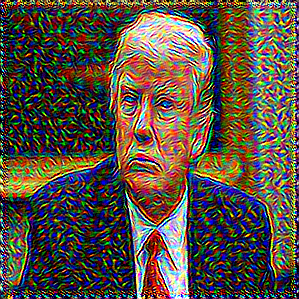

In [29]:
img = Image.fromarray(plt.imread('sample_images/img.jpg'))
img_adv = dd_helper(img, 5, 5, 5)
img_adv

In [30]:
predict(resize(np.asarray(img_adv), (299, 299)))

top-10 classes are: 
 [prob : class label]
0.8709 :	shower curtain
0.0097 :	velvet
0.0069 :	apron
0.0057 :	pillow
0.0052 :	binder
0.0052 :	book jacket
0.0046 :	sarong
0.0036 :	wallet
0.0032 :	bath towel
